# Parameter inference

This example illustrates parameter inference for a single model. (Check also the `model selection <model_selection.ipynb>`_ example if you're interested in comparing multiple models.)

This notebook can be downloaded here: `Parameter Inference <parameter_inference.ipynb>`.

Let's start by importing the necessary packages:

In [121]:
import pyabc
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import scipy
pyabc.settings.set_figure_params('pyabc')  # for beautified plots

## Problem definition

Our model is about as simple as it gets. We assume a Gaussian model $\mathcal{N}(\mu, 0.5^2)$ with a single parameter $\mu$ and fixed variance $0.5^2$.

Parameters (`Parameter <pyabc.parameters.Parameter>`) that are passed to the model are essentially dictionaries with keys the parameter ids and float values, generated in pyABC from the prior or a proposal distribution. In this case, there is only a single key, `mu`.

The model returns data in form of a dictionary, with keys denoting different outputs. In this case, there is just a single key `data`. Values can be e.g. floats, integers, strings, numpy arrays, or pandas data frames, see the `data store API documentation <api_datastore>` for details.
It might look like overly complicated to return a whole dictionary, but as soon as heterogeneous data are used, this starts to make a lot of sense.

In [122]:
def model(parameter):
    return {"data": parameter["mu"] + 0.5 * np.random.randn()}

We then define the prior for the mean. A `RV <pyabc.random_variables.RV>` defines the prior for a single parameter, while a `Distribution <pyabc.random_variables.Distribution>` defines the prior over a possibly higher-dimensional parameter space. The ``RV`` class is a shallow wrapper around `scipy.stats <https://docs.scipy.org/doc/scipy/reference/stats.html>`_ variables. In case of multiple independent priors, simply multiple RVs are passed to the distribution, while for non-independent or constrained priors, the ``Distribution`` class can be derived from.

In [123]:
prior = pyabc.Distribution(mu=pyabc.RV("norm", 2, 1))

<div class="alert alert-warning">
Note: A common mistake is that the scipy uniform distribution takes arguments `lower_bound, width`, the second argument not being the upper bound. For example, `RV("uniform", 1, 5)` is uniform over the interval $[1,6]$. Check the `scipy.stats` package for details of the definition.
</div>

We also need to specify a distance function, measuring closeness of simulated and observed data.
We just take the absolute value of the difference here.

In [96]:
def distance(x, x0):
    return abs(x["data"] - x0["data"])

## ABC inference

Now we create the `ABCSMC <pyabc.inference.ABCSMC>` object, the main inference class. It defines an ABC-SMC algorithm, which sequentially generates particle populations of size `N`, sampling in generation  `t` from a perturbation of accepted particles in generation  `t-1` via importance samling, thus from a successively improved posterior approximation, thus allowing to gradually reduce an acceptance threshold $\varepsilon$ on the permitted distance, while maintaining high acceptance rates.

We pass the model, the prior and the distance to the ``ABCSMC`` class, and use a population size of `N=1000`.

In [97]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=1000)

ABC.Sampler INFO: Parallelize sampling on 8 processes.


To get going, we have to specify where to log the ABC-SMC runs. pyABC uses an SQL database, see the `data store documentation <api_datastore>`. We can later query the database with the help of the `History <pyabc.storage.History>` class. Usually you would now have some measured data to base your analysis on. Here, we just assume that the measured data is 2.5.

In [124]:
db_path = os.path.join(tempfile.gettempdir(), "test.db")


In [ ]:
observation = 2.5
abc.new("sqlite:///" + db_path, {"data": observation})

ABC.History INFO: Start <ABCSMC id=9, start_time=2025-10-09 17:19:54>


Let's start the sampling now. We'll sample until the acceptance threshold epsilon drops below some value. We also specify a maximum number of SMC populations. So whatever is reached first, `minimum_epsilon` or `max_nr_populations`, will stop further sampling.

The acceptance thresholds are automatically calibrated and updated. This and further components such as proposal kernels and parallelization strategy (on Linux, per default multi-processing) can be modified via arguments to the ``ABCSMC` class, see the API documentation or further examples.

For the simple model we defined above, this should only take a couple of seconds:

In [99]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=10)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 8.77530617e-01.
ABC INFO: Accepted: 1000 / 1910 = 5.2356e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 4.10839095e-01.
ABC INFO: Accepted: 1000 / 2671 = 3.7439e-01, ESS: 8.9348e+02.
ABC INFO: t: 2, eps: 2.00063710e-01.
ABC INFO: Accepted: 1000 / 4486 = 2.2292e-01, ESS: 8.3750e+02.
ABC INFO: t: 3, eps: 1.02087223e-01.
ABC INFO: Accepted: 1000 / 8670 = 1.1534e-01, ESS: 8.2801e+02.
ABC INFO: t: 4, eps: 4.76261580e-02.
ABC INFO: Accepted: 1000 / 18078 = 5.5316e-02, ESS: 8.5942e+02.
ABC INFO: t: 5, eps: 2.41446427e-02.
ABC INFO: Accepted: 1000 / 32165 = 3.1090e-02, ESS: 6.5963e+02.
ABC INFO: t: 6, eps: 1.24567007e-02.
ABC INFO: Accepted: 1000 / 71306 = 1.4024e-02, ESS: 7.9936e+02.
ABC INFO: t: 7, eps: 6.02616909e-03.
ABC INFO: Accepted: 1000 / 144300 = 6.9300e-03, ESS: 7.2454e+02.
ABC INFO: Stop: Minimum epsilon.
ABC.History INFO: Done <ABCSMC id=8, duration=0:00:50.118373, end_time=2025-10-09 17:05:45>


The `History` object returned by `ABCSMC.run` can be used to query the database.
This object is also available via `abc.History("sqlite:///" + db_path)`.

In [153]:
history.get_distribution()[0].to_numpy().flatten()

array([2.39399875, 2.24237523, 1.87260435, 2.9775102 , 2.55105598,
       2.83633323, 2.84257784, 2.16633723, 2.84280263, 2.30601325,
       2.36435292, 2.96142818, 2.35820236, 2.61427315, 1.63109618,
       2.03692467, 1.92264364, 2.19807318, 1.93843706, 1.7790191 ,
       2.6195799 , 2.67655865, 2.30891402, 2.12387504, 2.23198896,
       3.2748562 , 2.36614496, 2.68786506, 2.08555334, 2.61490384,
       2.02319033, 2.37960151, 2.52937723, 2.77725386, 2.36345522,
       2.85692566, 2.29927845, 2.0754203 , 2.24396583, 2.24002918,
       3.2027389 , 2.75012992, 2.56263271, 1.84259105, 1.69712353,
       2.34166237, 2.7053674 , 2.7413506 , 2.24829046, 3.14745067,
       2.77393991, 2.06338092, 1.96570039, 2.32554034, 1.82544172,
       2.70883145, 2.67090945, 2.44343784, 2.70341897, 2.26329118,
       2.67914125, 2.63270013, 2.5386696 , 2.40196764, 2.6304043 ,
       3.10793653, 2.28843471, 2.77099097, 2.17478957, 2.46296975,
       2.64255377, 2.61537037, 2.24369074, 2.12191194, 1.83224

## Visualization and analysis of results

Now, we can visualize the obtained Bayesian posterior approximation.
The vertical line indicates the location of the observation, while the curves give the ABC posterior at different generations (usually, only the last one is of interest).
Given our model, we expect the mean to be close to the observed data, with some uncertainty. For more-dimensional parameter vectors, pyABC also offers `plot_kde_2d` and `plot_kde_matrix` plots.

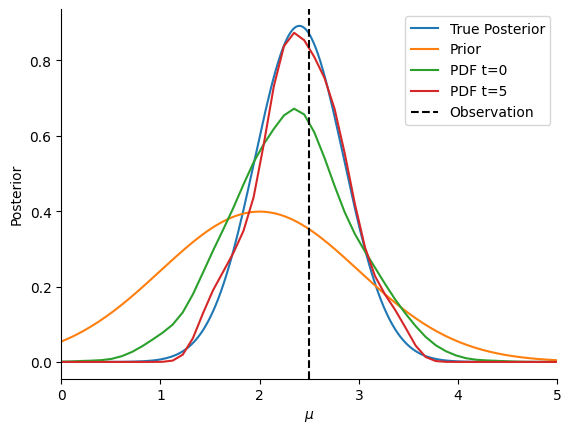

In [103]:
fig, ax = plt.subplots()
# Plot true analytical posterior
ax.plot(np.linspace(0,5,200), scipy.stats.norm.pdf(np.linspace(0,5,200), (4*observation+2)/5, np.sqrt(1/5)), label="True Posterior")
# Plot prior
ax.plot(np.linspace(0,5,200), scipy.stats.norm.pdf(np.linspace(0,5,200), 2, 1), label="Prior")
for t in np.arange(0, history.max_t + 1, 5, dtype=int):
    df, w = history.get_distribution(m=0, t=t)
    # Plots the Kernel Density Estimate (KDE) using the SMC-ABC samples and their weights. Mathematically, we must 
    # weight the samples using their SMC importance weights when calculating density estimates and expectations 
    # since it is the WEIGHTED versions that converge to the true posterior in the limit. 
    pyabc.visualization.plot_kde_1d(
        df,
        w,
        xmin=0,
        xmax=5,
        x="mu",
        xname=r"$\mu$",
        ax=ax,
        label=f"PDF t={t}",
    )
ax.axvline(observation, color="k", linestyle="dashed", label="Observation")
ax.legend();

pyABC also offers various other visualization routines in order to analyze the parameter estimation run, see the `visualization API documentation <_api_documentation>` for a full list.
In general, it is necessary after an ABC run to analyze the posterior estimation for e.g. convergence and stability, by assessing posterior approximations at different generations, as well as effective population sizes, possibly across multiple runs.

<Axes: title={'center': 'Effective sample size'}, xlabel='Population index', ylabel='ESS'>

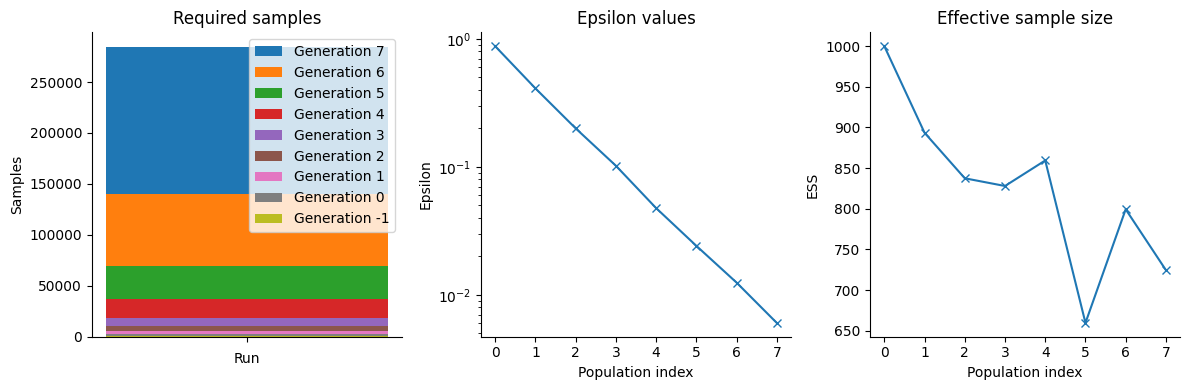

In [101]:
fig, arr_ax = plt.subplots(1, 3, figsize=(12, 4))

pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0])
pyabc.visualization.plot_epsilons(history, ax=arr_ax[1])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[2])



That's it. Now you can go ahead and try more sophisticated models.

# SBC on ABC-SMC

In [188]:
samp = prior.rvs()
samp.values()

dict_values([np.float64(2.0083779250634515)])

2.0083779250634515

In [175]:
model(samp)

{'data': np.float64(1.2975979131308948)}

In [219]:
def abc_smc_sbi(model, prior, distance, population_size=100, num_sbi_runs=100, minimum_epsilon=0.1, max_nr_populations=10):
    abc = pyabc.ABCSMC(model, prior, distance, population_size=population_size)
    db_path = os.path.join(tempfile.gettempdir(), "test.db") # String containing database path to store ABC_SMC runs
    ranks = []
    for i in range(num_sbi_runs):
        prior_sample = prior.rvs() # Sample from prior. Returns a pyabc <Parameter> object
        simulated_datapoint = model(prior_sample) # Simulate a datapoint from the model given the prior sample. Returns dict.
        abc.new("sqlite:///" + db_path, simulated_datapoint)
        history = abc.run(minimum_epsilon, max_nr_populations)
        posterior_samples = history.get_distribution()[0].to_numpy().flatten() # Numpy array of (population_size, ) samples.
        rank = np.sum(next(iter(prior_sample.values())).item() * np.ones_like(posterior_samples) > posterior_samples) # Rank statistic
        ranks.append(float(rank))
    plt.hist(ranks, label="SBC rank histogram")
    plt.xlim(0, population_size)
    plt.xlabel("Rank")
    plt.show()
    return ranks


ABC.Sampler INFO: Parallelize sampling on 8 processes.
ABC.History INFO: Start <ABCSMC id=22, start_time=2025-10-12 11:17:38>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 7.45141661e-01.
ABC INFO: Accepted: 20 / 48 = 4.1667e-01, ESS: 2.0000e+01.
ABC INFO: t: 1, eps: 5.17448123e-01.
ABC INFO: Accepted: 20 / 42 = 4.7619e-01, ESS: 1.9352e+01.
ABC INFO: t: 2, eps: 2.71505641e-01.
ABC INFO: Accepted: 20 / 58 = 3.4483e-01, ESS: 1.6356e+01.
ABC INFO: t: 3, eps: 1.86418792e-01.
ABC INFO: Accepted: 20 / 83 = 2.4096e-01, ESS: 1.3241e+01.
ABC INFO: t: 4, eps: 7.62705092e-02.
ABC INFO: Accepted: 20 / 424 = 4.7170e-02, ESS: 1.9868e+01.
ABC INFO: Stop: Minimum epsilon.
ABC.History INFO: Done <ABCSMC id=22, duration=0:00:19.966929, end_time=2025-10-12 11:17:58>
ABC.History INFO: Start <ABCSMC id=23, start_time=2025-10-12 11:17:58>
ABC INFO: t: 0, eps: 8.53882884e-01.
ABC INFO: Accepted: 20 / 38 = 5.2632e-01, ESS: 2.0000e+01.
ABC INFO: t: 1, eps: 3.39089455e-01.
ABC INFO: Accepted: 20 / 7

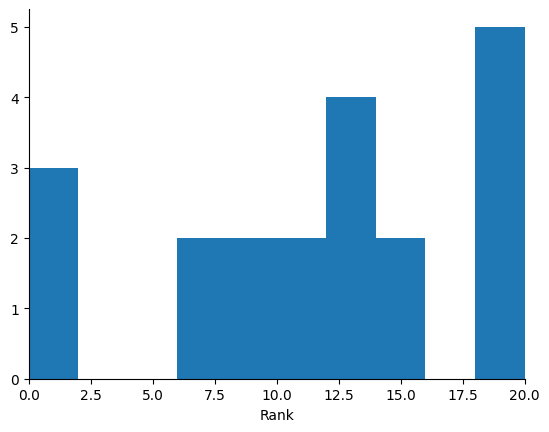

[14.0,
 11.0,
 20.0,
 13.0,
 6.0,
 0.0,
 8.0,
 8.0,
 12.0,
 12.0,
 18.0,
 20.0,
 7.0,
 0.0,
 10.0,
 13.0,
 1.0,
 15.0,
 20.0,
 19.0]

In [220]:
abc_smc_sbi(model, prior, distance, population_size=20, num_sbi_runs=20)